In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from datetime import date, datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def get_weather_forecast(dates, location="Rust, Germany"):
    import requests
    from datetime import datetime
    
    weather_data = []
    
    print(f"Fetching weather for {location}...")
    
    for date_obj in dates:
        try:
            date_str = date_obj.strftime("%Y-%m-%d")
            
            url = f"https://wttr.in/{location.replace(' ', '+')}?format=j1&date={date_str}"
            
            response = requests.get(url, timeout=10)
            
            if response.status_code == 200:
                data = response.json()
                
                if 'weather' in data and len(data['weather']) > 0:
                    day_weather = data['weather'][0]
                    
                    temp_c = float(day_weather.get('avgtempC', 20))
                    
                    precip_mm = float(day_weather.get('totalSnow_cm', 0)) + float(day_weather.get('precipMM', 0))
                    
                    wind_kmh = float(day_weather.get('uvIndex', 10))
                    if 'hourly' in day_weather and len(day_weather['hourly']) > 0:
                        wind_kmh = float(day_weather['hourly'][0].get('windspeedKmph', 10))
                    
                    weather_data.append({
                        'date': pd.to_datetime(date_obj),
                        'temperature': temp_c,
                        'rain': precip_mm,
                        'wind': wind_kmh
                    })
                    
                    print(f"  {date_str}: {temp_c}°C, {precip_mm}mm rain, {wind_kmh}km/h wind")
                
                else:
                    weather_data.append({
                        'date': pd.to_datetime(date_obj),
                        'temperature': 20,
                        'rain': 0,
                        'wind': 10
                    })
                    print(f"  {date_str}: Using defaults (API data incomplete)")
            
            else:
                weather_data.append({
                    'date': pd.to_datetime(date_obj),
                    'temperature': 20,
                    'rain': 0,
                    'wind': 10
                })
                print(f"  {date_str}: API error, using defaults")
        
        except Exception as e:
            weather_data.append({
                'date': pd.to_datetime(date_obj),
                'temperature': 20,
                'rain': 0, 
                'wind': 10
            })
            print(f"  {date_str}: Error ({e}), using defaults")
    
    return pd.DataFrame(weather_data)

In [ ]:
def load_and_split_data(file_path, test_year=2023):
    df = pd.read_parquet(file_path)
    
    print(f"Loaded data with shape: {df.shape}")
    print(f"Sample columns: {list(df.columns)[:20]}...")
    
    print(f"Checking for existing timestamp column...")
    print(f"Available non-ride columns: {[col for col in df.columns if not col.startswith('ride_name_')][:15]}")
    
    if 'timestamp' in df.columns:
        print("Found existing timestamp column")
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['year'] = df['timestamp'].dt.year
        df['month'] = df['timestamp'].dt.month
        df['day'] = df['timestamp'].dt.day
        df['hour'] = df['timestamp'].dt.hour
        df['date'] = df['timestamp'].dt.date
        df['day_of_week'] = df['timestamp'].dt.dayofweek
    else:
        print("No timestamp column found, extracting from one-hot encoded columns...")
        
        ride_name_cols = [col for col in df.columns if col.startswith('ride_name_')]
        if ride_name_cols:
            df['ride_name'] = df[ride_name_cols].idxmax(axis=1).str.replace('ride_name_', '')
        else:
            print("Warning: No ride_name columns found")
            df['ride_name'] = 'unknown'
        
        year_cols = [col for col in df.columns if col.startswith('year_') and col.replace('year_', '').isdigit()]
        if year_cols:
            df['year'] = df[year_cols].idxmax(axis=1).str.replace('year_', '').astype(int)
        else:
            print("Warning: No year columns found, using default")
            df['year'] = 2022
        
        month_cols = [col for col in df.columns if col.startswith('month_') and 
                      col.replace('month_', '').isdigit()]
        if month_cols:
            df['month'] = df[month_cols].idxmax(axis=1).str.replace('month_', '').astype(int)
        else:
            print("Warning: No month columns found, extracting from cyclical features")
            if 'month_sin' in df.columns and 'month_cos' in df.columns:
                month_angle = np.arctan2(df['month_sin'], df['month_cos'])
                df['month'] = ((month_angle / (2 * np.pi) * 12) + 12) % 12 + 1
                df['month'] = df['month'].round().astype(int).clip(1, 12)
            else:
                df['month'] = 6
        
        if 'weekday' in df.columns:
            df['day_of_week'] = df['weekday']
        elif 'day_of_week' in df.columns:
            pass
        elif 'weekday_sin' in df.columns and 'weekday_cos' in df.columns:
            weekday_angle = np.arctan2(df['weekday_sin'], df['weekday_cos'])
            df['day_of_week'] = ((weekday_angle / (2 * np.pi) * 7) + 7) % 7
            df['day_of_week'] = df['day_of_week'].round().astype(int) % 7
        else:
            print("Warning: No day_of_week info found")
            df['day_of_week'] = 1
        
        if 'hour_sin' in df.columns and 'hour_cos' in df.columns:
            hour_angle = np.arctan2(df['hour_sin'], df['hour_cos'])
            df['hour'] = ((hour_angle / (2 * np.pi) * 24) + 24) % 24
            df['hour'] = df['hour'].round().astype(int) % 24
        else:
            print("Warning: No hour info found")
            df['hour'] = 12
        
        df['day'] = 15
        
        try:
            df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
            df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
        except Exception as e:
            print(f"Error creating timestamp: {e}")
            df['month'] = df['month'].clip(1, 12)
            df['day'] = df['day'].clip(1, 28)
            df['hour'] = df['hour'].clip(0, 23)
            df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
            df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    
    print(f"Data years available: {sorted(df['year'].unique())}")
    print(f"Data months available: {sorted(df['month'].unique())}")
    print(f"Data weekdays available: {sorted(df['day_of_week'].unique())}")
    print(f"Data hours available: {sorted(df['hour'].unique())}")
    print(f"Sample timestamps: {df['timestamp'].head()}")
    
    covid_mask = (df['year'] >= 2020) & (df['year'] <= 2021)
    covid_data_count = covid_mask.sum()
    
    if covid_data_count > 0:
        print(f"⚠️  Filtering out {covid_data_count} COVID-period records (2020-2021)")
        df = df[~covid_mask]
    
    reasonable_hours = (df['hour'] >= 9) & (df['hour'] <= 21)
    before_filter = len(df)
    df = df[reasonable_hours]
    print(f"Filtered to operating hours (9-21): {len(df)} records (removed {before_filter - len(df)})")
    
    train_mask = df['year'] < test_year
    test_mask = df['year'] == test_year
    
    train_data = df[train_mask].copy()
    test_data = df[test_mask].copy()
    
    print(f"Train data: {len(train_data)} samples")
    print(f"Test data: {len(test_data)} samples")
    
    if len(train_data) > 0:
        print(f"Date range - Train: {train_data['timestamp'].min()} to {train_data['timestamp'].max()}")
        print(f"Train weekdays: {sorted(train_data['day_of_week'].unique())}")
    if len(test_data) > 0:
        print(f"Date range - Test: {test_data['timestamp'].min()} to {test_data['timestamp'].max()}")
        print(f"Test weekdays: {sorted(test_data['day_of_week'].unique())}")
    
    return train_data, test_data

In [ ]:
def check_data_quality(df):
    print("=== Data Quality Check ===")
    print(f"Total records: {len(df)}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Unique dates: {df['date'].nunique()}")
    print(f"Hours per day (avg): {len(df) / df['date'].nunique():.1f}")
    
    dow_counts = df['day_of_week'].value_counts().sort_index()
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    print("\nRecords by day of week:")
    for i, day in enumerate(days):
        count = dow_counts.get(i, 0)
        print(f"  {day}: {count} records")
    
    hour_counts = df['hour'].value_counts().sort_index()
    print(f"\nHour range: {df['hour'].min()}-{df['hour'].max()}")
    print(f"Hours with <100 records: {(hour_counts < 100).sum()}")
    
    print(f"\nWait time stats:")
    print(f"  Min: {df['wait_time'].min():.1f} minutes")
    print(f"  Max: {df['wait_time'].max():.1f} minutes")
    print(f"  Mean: {df['wait_time'].mean():.1f} minutes")
    print(f"  Zero wait times: {(df['wait_time'] == 0).sum()} records")
    
    return df

In [ ]:
def create_temporal_wait_features(ride_data):
    print(f"Creating temporal wait time features for {len(ride_data)} data points...")
    
    ride_data = ride_data.sort_values(['date', 'timestamp']).copy()
    
    temporal_features = []
    
    for date, day_data in ride_data.groupby('date'):
        day_data = day_data.sort_values('timestamp').copy()
        
        day_data['wait_time_lag_1h'] = day_data['wait_time'].shift(1)
        day_data['wait_time_lag_2h'] = day_data['wait_time'].shift(2)
        day_data['wait_time_lag_3h'] = day_data['wait_time'].shift(3)
        
        day_data['rolling_avg_2h'] = day_data['wait_time'].shift(1).rolling(window=2, min_periods=1).mean()
        day_data['rolling_avg_3h'] = day_data['wait_time'].shift(1).rolling(window=3, min_periods=1).mean()
        
        day_data['rolling_max_3h'] = day_data['wait_time'].shift(1).rolling(window=3, min_periods=1).max()
        
        day_data['wait_trend_1h'] = day_data['wait_time'] - day_data['wait_time_lag_1h']
        day_data['wait_trend_2h'] = day_data['rolling_avg_2h'] - day_data['wait_time_lag_2h']
        
        if len(day_data) > 0:
            first_hour = day_data['hour'].min()
            day_data['hours_since_opening'] = day_data['hour'] - first_hour
        else:
            day_data['hours_since_opening'] = 0
            
        morning_mask = day_data['hours_since_opening'] <= 3
        if morning_mask.sum() > 0:
            morning_avg = day_data[morning_mask]['wait_time'].mean()
            day_data['morning_avg_wait'] = morning_avg
        else:
            day_data['morning_avg_wait'] = 0
            
        day_data['is_daily_peak_so_far'] = (
            day_data['wait_time'] == day_data['wait_time'].shift(1).expanding().max()
        ).astype(int)
        
        day_data['is_local_peak'] = (
            (day_data['wait_time'] > day_data['wait_time'].shift(1)) & 
            (day_data['wait_time'] > day_data['wait_time'].shift(-1))
        ).astype(int)
        
        day_data['wait_acceleration'] = (
            day_data['wait_trend_1h'] - day_data['wait_trend_1h'].shift(1)
        ).fillna(0)
        
        if len(day_data) > 1:
            hourly_expected = day_data.groupby('hour')['wait_time'].transform('mean')
            day_data['wait_vs_hourly_expected'] = day_data['wait_time'] - hourly_expected
        else:
            day_data['wait_vs_hourly_expected'] = 0
        
        temporal_features.append(day_data)
    
    result = pd.concat(temporal_features, ignore_index=True)
    
    temporal_cols = [
        'wait_time_lag_1h', 'wait_time_lag_2h', 'wait_time_lag_3h',
        'rolling_avg_2h', 'rolling_avg_3h', 'rolling_max_3h',
        'wait_trend_1h', 'wait_trend_2h', 'morning_avg_wait',
        'wait_acceleration', 'wait_vs_hourly_expected'
    ]
    
    for col in temporal_cols:
        if col in result.columns:
            result[col] = result[col].fillna(0)
    
    print(f"Created temporal features: {temporal_cols}")
    return result

In [ ]:
def calculate_hourly_attendance_metrics(ride_data):
    print(f"Calculating hourly attendance metrics for {len(ride_data)} data points...")
    
    ride_data_with_temporal = create_temporal_wait_features(ride_data)
    
    log_wait = np.log1p(ride_data_with_temporal['wait_time'])
    
    base_score = log_wait.rank(pct=True) * 100
    
    if 'rolling_avg_2h' in ride_data_with_temporal.columns:
        log_rolling = np.log1p(ride_data_with_temporal['rolling_avg_2h'])
        historical_score = log_rolling.rank(pct=True) * 100
        
        combined_score = 0.7 * base_score + 0.3 * historical_score
    else:
        combined_score = base_score
    
    hourly_scores = []
    for hour in ride_data_with_temporal['hour'].unique():
        hour_mask = ride_data_with_temporal['hour'] == hour
        if hour_mask.sum() > 10:
            hour_data = ride_data_with_temporal[hour_mask]['wait_time']
            if len(hour_data) > 1 and hour_data.std() > 0:
                hour_percentiles = hour_data.rank(pct=True) * 100
                hourly_blend = 0.8 * combined_score[hour_mask] + 0.2 * hour_percentiles
                hourly_scores.append(pd.Series(hourly_blend.values, index=hour_mask[hour_mask].index))
    
    if hourly_scores:
        final_score = combined_score.copy()
        for hourly_score in hourly_scores:
            final_score.update(hourly_score)
        ride_data_with_temporal['attendance_score'] = final_score
    else:
        ride_data_with_temporal['attendance_score'] = combined_score
    
    ride_data_with_temporal['attendance_score'] = ride_data_with_temporal['attendance_score'].clip(0, 100)
    
    np.random.seed(42)
    noise = np.random.normal(0, 0.5, len(ride_data_with_temporal))
    ride_data_with_temporal['attendance_score'] = (
        ride_data_with_temporal['attendance_score'] + noise
    ).clip(0, 100)
    
    ride_data_with_temporal['year'] = ride_data_with_temporal['timestamp'].dt.year
    ride_data_with_temporal['month'] = ride_data_with_temporal['timestamp'].dt.month
    ride_data_with_temporal['day_of_month'] = ride_data_with_temporal['timestamp'].dt.day
    ride_data_with_temporal['day_of_week'] = ride_data_with_temporal['timestamp'].dt.dayofweek
    ride_data_with_temporal['day_of_year'] = ride_data_with_temporal['timestamp'].dt.dayofyear
    ride_data_with_temporal['is_weekend'] = (ride_data_with_temporal['day_of_week'] >= 5).astype(int)
    
    conditions = [
        (ride_data_with_temporal['month'] >= 3) & (ride_data_with_temporal['month'] <= 5),
        (ride_data_with_temporal['month'] >= 6) & (ride_data_with_temporal['month'] <= 8),
        (ride_data_with_temporal['month'] >= 9) & (ride_data_with_temporal['month'] <= 11),
        (ride_data_with_temporal['month'] == 12) | (ride_data_with_temporal['month'] <= 2)
    ]
    seasons = ['spring', 'summer', 'fall', 'winter']
    ride_data_with_temporal['season'] = np.select(conditions, seasons, default='unknown')
    
    ride_data_with_temporal['month_sin'] = np.sin(2 * np.pi * ride_data_with_temporal['month'] / 12)
    ride_data_with_temporal['month_cos'] = np.cos(2 * np.pi * ride_data_with_temporal['month'] / 12)
    ride_data_with_temporal['day_of_week_sin'] = np.sin(2 * np.pi * ride_data_with_temporal['day_of_week'] / 7)
    ride_data_with_temporal['day_of_week_cos'] = np.cos(2 * np.pi * ride_data_with_temporal['day_of_week'] / 7)
    ride_data_with_temporal['day_of_year_sin'] = np.sin(2 * np.pi * ride_data_with_temporal['day_of_year'] / 365.25)
    ride_data_with_temporal['day_of_year_cos'] = np.cos(2 * np.pi * ride_data_with_temporal['day_of_year'] / 365.25)
    ride_data_with_temporal['hour_sin'] = np.sin(2 * np.pi * ride_data_with_temporal['hour'] / 24)
    ride_data_with_temporal['hour_cos'] = np.cos(2 * np.pi * ride_data_with_temporal['hour'] / 24)
    
    print(f"Created hourly attendance metrics for {len(ride_data_with_temporal)} data points")
    print(f"Attendance score range: {ride_data_with_temporal['attendance_score'].min():.1f} - {ride_data_with_temporal['attendance_score'].max():.1f}")
    
    return ride_data_with_temporal

In [ ]:
def train_attendance_prediction_model(hourly_attendance_data, target_metric='attendance_score'):
    from sklearn.ensemble import GradientBoostingRegressor
    
    print(f"Training attendance prediction model for {target_metric}...")
    
    cat_features = ['season']
    
    calendar_features = [
        'month', 'day_of_month', 'day_of_week', 'day_of_year', 'hour', 'is_weekend',
        'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
        'day_of_year_sin', 'day_of_year_cos', 'hour_sin', 'hour_cos'
    ]
    
    weather_features = ['temperature', 'rain', 'wind']
    holiday_features = ['is_german_holiday', 'is_swiss_holiday', 'is_french_holiday']
    operational_features = ['closed']
    
    available_features = []
    missing_features = []
    
    for feature_group_name, feature_group in [
        ("calendar", calendar_features),
        ("weather", weather_features), 
        ("holiday", holiday_features),
        ("operational", operational_features)
    ]:
        for feature in feature_group:
            if feature in hourly_attendance_data.columns:
                available_features.append(feature)
            else:
                missing_features.append(feature)
    
    if missing_features:
        print(f"Missing features (will be skipped): {missing_features}")
    
    print(f"Available features for training: {available_features}")
    
    num_features = available_features
    
    hourly_attendance_data = hourly_attendance_data.sort_values('timestamp')
    
    split_idx = int(len(hourly_attendance_data) * 0.8)
    train_data = hourly_attendance_data.iloc[:split_idx]
    test_data = hourly_attendance_data.iloc[split_idx:]
    
    print(f"Attendance training data: {len(train_data)} hours, Test data: {len(test_data)} hours")
    print(f"Training period: {train_data['timestamp'].min()} to {train_data['timestamp'].max()}")
    print(f"Testing period: {test_data['timestamp'].min()} to {test_data['timestamp'].max()}")
    
    cat_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    num_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', cat_transformer, cat_features),
            ('num', num_transformer, num_features)
        ]
    )
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        ))
    ])
    
    X_train = train_data[cat_features + num_features]
    y_train = train_data[target_metric]
    
    if X_train.isna().any().any():
        print("Filling remaining NaN values in training data...")
        for col in X_train.columns:
            if X_train[col].isna().any():
                if X_train[col].dtype in ['object', 'category']:
                    X_train[col] = X_train[col].fillna('unknown')
                else:
                    X_train[col] = X_train[col].fillna(0)
    
    model.fit(X_train, y_train)
    
    X_test = test_data[cat_features + num_features]
    y_test = test_data[target_metric]
    
    if X_test.isna().any().any():
        print("Filling remaining NaN values in test data...")
        for col in X_test.columns:
            if X_test[col].isna().any():
                if X_test[col].dtype in ['object', 'category']:
                    X_test[col] = X_test[col].fillna('unknown')
                else:
                    X_test[col] = X_test[col].fillna(0)
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Attendance Model - Test MAE: {mae:.2f}")
    print(f"Attendance Model - Test RMSE: {rmse:.2f}")
    print(f"Attendance Model - Test R²: {r2:.4f}")
    
    if hasattr(model['regressor'], 'feature_importances_'):
        feature_names = []
        for name, transformer, features in preprocessor.transformers_:
            if name == 'cat':
                if hasattr(transformer.named_steps['onehot'], 'get_feature_names_out'):
                    encoded_names = transformer.named_steps['onehot'].get_feature_names_out(features)
                    feature_names.extend(encoded_names)
            else:
                feature_names.extend(features)
        
        if len(feature_names) == len(model['regressor'].feature_importances_):
            coef_df = pd.DataFrame({
                'feature': feature_names,
                'importance': model['regressor'].feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"\nTop 10 most important features for attendance prediction:")
            for _, row in coef_df.head(10).iterrows():
                print(f"  {row['feature']}: {row['importance']:.4f}")
            
            print(f"\nNote: Temporal wait features were excluded from model training")
            temporal_features_available = [col for col in hourly_attendance_data.columns 
                                         if any(temp in col for temp in ['lag', 'rolling', 'trend', 'morning', 'peak'])]
            if temporal_features_available:
                print(f"Available temporal features (not used): {temporal_features_available[:5]}...")
    
    return {
        'model': model,
        'metrics': {'mae': mae, 'rmse': rmse, 'r2': r2},
        'features': {'cat_features': cat_features, 'num_features': num_features},
        'target_metric': target_metric,
        'test_predictions': {'y_test': y_test, 'y_pred': y_pred, 'test_data': test_data}
    }


In [ ]:
def predict_attendance_for_timestamps(timestamps, attendance_model, historical_wait_times=None):
    cat_features = attendance_model['features']['cat_features']
    num_features = attendance_model['features']['num_features']
    
    predictions = []
    
    for timestamp in timestamps:
        if isinstance(timestamp, str):
            timestamp = pd.to_datetime(timestamp)
            
        features = {
            'timestamp': timestamp,
            'month': timestamp.month,
            'day_of_month': timestamp.day,
            'day_of_week': timestamp.weekday(),
            'day_of_year': timestamp.timetuple().tm_yday,
            'hour': timestamp.hour,
            'is_weekend': 1 if timestamp.weekday() >= 5 else 0,
        }
        
        if timestamp.month in [3, 4, 5]:
            features['season'] = 'spring'
        elif timestamp.month in [6, 7, 8]:
            features['season'] = 'summer'
        elif timestamp.month in [9, 10, 11]:
            features['season'] = 'fall'
        else:
            features['season'] = 'winter'
        
        features['month_sin'] = np.sin(2 * np.pi * timestamp.month / 12)
        features['month_cos'] = np.cos(2 * np.pi * timestamp.month / 12)
        features['day_of_week_sin'] = np.sin(2 * np.pi * timestamp.weekday() / 7)
        features['day_of_week_cos'] = np.cos(2 * np.pi * timestamp.weekday() / 7)
        features['day_of_year_sin'] = np.sin(2 * np.pi * timestamp.timetuple().tm_yday / 365.25)
        features['day_of_year_cos'] = np.cos(2 * np.pi * timestamp.timetuple().tm_yday / 365.25)
        features['hour_sin'] = np.sin(2 * np.pi * timestamp.hour / 24)
        features['hour_cos'] = np.cos(2 * np.pi * timestamp.hour / 24)
        
        features['temperature'] = 20.0
        features['rain'] = 0.0
        features['wind'] = 5.0
        features['closed'] = 0
        features['is_german_holiday'] = 0
        features['is_swiss_holiday'] = 0
        features['is_french_holiday'] = 0
        
        timestamp_features = []
        for feature in cat_features + num_features:
            if feature in features:
                timestamp_features.append(features[feature])
            else:
                if feature in cat_features:
                    timestamp_features.append('unknown')
                else:
                    timestamp_features.append(0)
        
        timestamps_df = pd.DataFrame([dict(zip(cat_features + num_features, timestamp_features))])
        
        X_pred = timestamps_df[cat_features + num_features]
        
        for col in X_pred.columns:
            if X_pred[col].isna().any():
                if X_pred[col].dtype in ['object', 'category']:
                    X_pred[col] = X_pred[col].fillna('unknown')
                else:
                    X_pred[col] = X_pred[col].fillna(0)
        
        attendance_pred = attendance_model['model'].predict(X_pred)[0]
        
        predictions.append({
            'timestamp': timestamp,
            'attendance_score': attendance_pred
        })
    
    return pd.DataFrame(predictions)


In [ ]:
def prepare_features_with_attendance(df, attendance_predictions=None):
    exclude_cols = ['wait_time', 'ride_name', 'year', 'date', 'month', 'day', 'hour', 'timestamp']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    X_temp = df[feature_cols]
    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns.tolist()
    
    X = X_temp[numeric_cols].copy()
    y = df['wait_time']
    
    if 'attendance_score' in df.columns:
        print(f"Found attendance_score column with {df['attendance_score'].notna().sum()} valid values")
        if 'attendance_score' not in X.columns:
            X['attendance_score'] = df['attendance_score']
    
    elif attendance_predictions is not None:
        df_with_attendance = df.merge(attendance_predictions, on='date', how='left')
        
        if 'attendance_score' in df_with_attendance.columns:
            X['attendance_score'] = df_with_attendance['attendance_score']
            print(f"Added attendance_score feature with {X['attendance_score'].notna().sum()} valid values")
    
    if 'attendance_score' in X.columns and X['attendance_score'].isna().any():
        median_attendance = X['attendance_score'].median()
        missing_count = X['attendance_score'].isna().sum()
        X['attendance_score'] = X['attendance_score'].fillna(median_attendance)
        print(f"Filled {missing_count} missing attendance values with median: {median_attendance:.1f}")
    
    nan_count = X.isna().sum().sum()
    if nan_count > 0:
        print(f"NaN values found: {nan_count}")
        for col in X.columns:
            if X[col].isna().sum() > 0:
                X[col] = X[col].fillna(X[col].median())
    
    if y.isna().sum() > 0:
        print(f"Dropping {y.isna().sum()} rows with NaN target values...")
        mask = ~y.isna()
        X = X[mask]
        y = y[mask]
    
    print(f"Selected {len(X.columns)} features: {list(X.columns)}")
    print(f"Final feature shape: {X.shape}")
    
    return X, y

In [ ]:
def prepare_features_without_attendance(df):
    exclude_cols = ['wait_time', 'ride_name', 'year', 'date', 'month', 'day', 'hour', 'timestamp', 'attendance_score']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    X_temp = df[feature_cols]
    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns.tolist()
    
    X = X_temp[numeric_cols].copy()
    y = df['wait_time']
    
    nan_count = X.isna().sum().sum()
    if nan_count > 0:
        print(f"NaN values found: {nan_count}")
        for col in X.columns:
            if X[col].isna().sum() > 0:
                X[col] = X[col].fillna(X[col].median())
    
    if y.isna().sum() > 0:
        print(f"Dropping {y.isna().sum()} rows with NaN target values...")
        mask = ~y.isna()
        X = X[mask]
        y = y[mask]
    
    print(f"Selected {len(X.columns)} features (without attendance): {list(X.columns)}")
    print(f"Final feature shape: {X.shape}")
    
    return X, y

In [ ]:
def train_wait_time_model(X_train, y_train):
    from sklearn.ensemble import GradientBoostingRegressor
    
    scaler = StandardScaler()
    model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    
    X_train_scaled = scaler.fit_transform(X_train)
    model.fit(X_train_scaled, y_train)
    
    return scaler, model


In [ ]:
def evaluate_wait_time_model(scaler, model, X_test, y_test, model_name=""):
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)
    y_pred = np.maximum(y_pred, 0)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    epsilon = 1e-8
    abs_pct_errors = np.abs(y_test - y_pred) / (np.abs(y_test) + epsilon)
    non_zero_mask = y_test > 0
    mape = np.mean(abs_pct_errors[non_zero_mask]) * 100
    
    print(f"{model_name} - Test MAE: {mae:.2f} minutes")
    print(f"{model_name} - Test RMSE: {rmse:.2f} minutes")
    print(f"{model_name} - Test R²: {r2:.4f}")
    print(f"{model_name} - Test MAPE: {mape:.2f}%")
    
    wait_ranges = [(0, 10), (10, 30), (30, 60), (60, float('inf'))]
    for min_wait, max_wait in wait_ranges:
        mask = (y_test >= min_wait) & (y_test < max_wait)
        if np.sum(mask) > 0:
            range_mae = mean_absolute_error(y_test[mask], y_pred[mask])
            print(f"MAE for {min_wait}-{max_wait if max_wait != float('inf') else '∞'} min: {range_mae:.2f} (n={np.sum(mask)})")
    
    return mae, rmse, r2, mape, y_pred

In [ ]:
def visualize_attendance_predictions(attendance_model, hourly_attendance_data):
    test_data = attendance_model['test_predictions']['test_data']
    y_test = attendance_model['test_predictions']['y_test']
    y_pred = attendance_model['test_predictions']['y_pred']
    target_metric = attendance_model['target_metric']
    
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel(f'Actual {target_metric}')
    plt.ylabel(f'Predicted {target_metric}')
    plt.title(f'Attendance Model: Actual vs Predicted {target_metric}')
    plt.grid(True, linestyle=':')
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}"
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    if len(test_data) > 10:
        plt.figure(figsize=(12, 6))
        
        comparison_df = pd.DataFrame({
            'timestamp': test_data['timestamp'].values,
            'actual': y_test.values,
            'predicted': y_pred
        }).sort_values('timestamp')
        
        if len(comparison_df) > 500:
            comparison_df = comparison_df.iloc[::len(comparison_df)//500]
        
        plt.plot(comparison_df['timestamp'], comparison_df['actual'], 'o-', label='Actual', alpha=0.7, markersize=2)
        plt.plot(comparison_df['timestamp'], comparison_df['predicted'], 's-', label='Predicted', alpha=0.7, markersize=2)
        plt.xlabel('Timestamp')
        plt.ylabel(target_metric)
        plt.title(f'Attendance Model: {target_metric} Over Time')
        plt.legend()
        plt.grid(True, linestyle=':')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    if 'hour' in hourly_attendance_data.columns and 'day_of_week' in hourly_attendance_data.columns:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        hourly_avg = hourly_attendance_data.groupby('hour')['attendance_score'].mean()
        plt.plot(hourly_avg.index, hourly_avg.values, 'o-')
        plt.xlabel('Hour of Day')
        plt.ylabel('Average Attendance Score')
        plt.title('Attendance Patterns by Hour')
        plt.grid(True, linestyle=':')
        
        plt.subplot(1, 2, 2)
        daily_avg = hourly_attendance_data.groupby('day_of_week')['attendance_score'].mean()
        days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        plt.bar(range(len(daily_avg)), daily_avg.values)
        plt.xlabel('Day of Week')
        plt.ylabel('Average Attendance Score')
        plt.title('Attendance Patterns by Day of Week')
        plt.xticks(range(len(days)), days)
        plt.grid(True, linestyle=':')
        
        plt.tight_layout()
        plt.show()
    
    print(f"\nTop 5 highest attendance hours (actual):")
    top_hours = hourly_attendance_data.nlargest(5, 'attendance_score')[['timestamp', 'attendance_score', 'wait_time']]
    for _, row in top_hours.iterrows():
        print(f"  {row['timestamp']}: Score {row['attendance_score']:.0f}, Wait Time {row['wait_time']:.1f}min")
    
    print(f"\nTop 5 lowest attendance hours (actual):")
    bottom_hours = hourly_attendance_data.nsmallest(5, 'attendance_score')[['timestamp', 'attendance_score', 'wait_time']]
    for _, row in bottom_hours.iterrows():
        print(f"  {row['timestamp']}: Score {row['attendance_score']:.0f}, Wait Time {row['wait_time']:.1f}min")

In [ ]:
def visualize_wait_time_results(y_test, y_pred, test_data, title_suffix=""):
    y_pred = np.maximum(y_pred, 0)
    
    ride_name_cols = [col for col in test_data.columns if col.startswith('ride_name_')]
    if ride_name_cols:
        test_data_viz = test_data.copy()
        test_data_viz['ride_name'] = test_data_viz[ride_name_cols].idxmax(axis=1).str.replace('ride_name_', '')
        ride_names = test_data_viz['ride_name'].values
    else:
        ride_names = ['unknown'] * len(y_test)
    
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_pred - y_test,
        'ride_name': ride_names
    })

    fig, axes = plt.subplots(2, 1, figsize=(14, 12))

    axes[0].scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    axes[0].plot([0, max_val], [0, max_val], 'r--')
    axes[0].set_xlabel('Actual Wait Time (minutes)')
    axes[0].set_ylabel('Predicted Wait Time (minutes)')
    axes[0].set_title(f'Wait Time Model: Actual vs Predicted {title_suffix}')
    axes[0].grid(True, linestyle=':')

    mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
    rmse = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Predicted']))
    r2 = r2_score(results_df['Actual'], results_df['Predicted'])
    
    metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}"
    axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes, 
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    sample_size = min(2000, len(results_df))
    results_sample = results_df.sample(n=sample_size, random_state=42)
    
    axes[1].scatter(range(len(results_sample)), results_sample['Actual'], 
                   label='Actual', alpha=0.7, s=1)
    axes[1].scatter(range(len(results_sample)), results_sample['Predicted'], 
                   label='Predicted', alpha=0.7, s=1)
    axes[1].set_xlabel('Sample Index')
    axes[1].set_ylabel('Wait Time (minutes)')
    axes[1].set_title(f'Wait Time Model: Sample Predictions {title_suffix}')
    axes[1].grid(True, linestyle=':')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    
    bins = [0, 10, 20, 30, 40, 50, 60, np.inf]
    labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']
    
    results_df['wait_bin'] = pd.cut(results_df['Actual'], bins=bins, labels=labels, include_lowest=True)
    
    bin_metrics = results_df.groupby('wait_bin').agg({
        'Error': ['mean', 'std'],
        'Actual': 'count'
    })
    
    bin_metrics.columns = ['Mean Error', 'Std Error', 'Count']
    bin_metrics['Abs Mean Error'] = results_df.groupby('wait_bin')['Error'].apply(lambda x: np.abs(x).mean())
    
    bin_metrics = bin_metrics[bin_metrics['Count'] > 0]
    
    plt.bar(range(len(bin_metrics)), bin_metrics['Abs Mean Error'], alpha=0.7)
    plt.xlabel('Actual Wait Time Range (minutes)')
    plt.ylabel('Mean Absolute Error (minutes)')
    plt.title(f'Error by Wait Time Range {title_suffix}')
    plt.xticks(range(len(bin_metrics)), bin_metrics.index)
    
    for i, count in enumerate(bin_metrics['Count']):
        plt.text(i, bin_metrics['Abs Mean Error'].iloc[i] + 0.5, f"n={count}", 
                 ha='center', va='bottom', fontsize=8)
    
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()
    
    return results_df

In [ ]:
def visualize_future_predictions(predictions_df, title="Future Wait Time Predictions"):
    pivot_table = predictions_df.pivot_table(
        index='date',
        columns='hour',
        values='predicted_wait'
    )
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        pivot_table, 
        annot=True, 
        fmt='.1f', 
        cmap='YlOrRd',
        linewidths=.5
    )
    plt.title(title)
    plt.xlabel('Hour of Day')
    plt.ylabel('Date')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    for date in predictions_df['date'].unique():
        date_data = predictions_df[predictions_df['date'] == date]
        plt.plot(date_data['hour'], date_data['predicted_wait'], 'o-', 
                label=str(date), alpha=0.8, markersize=4)
    
    plt.xlabel('Hour of Day')
    plt.ylabel('Predicted Wait Time (minutes)')
    plt.title(f'{title} - By Hour')
    plt.grid(True, linestyle=':')
    plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
def predict_future_wait_times(scaler, model, attendance_model, future_dates, future_hours, sample_features):
    future_timestamps = []
    for date_obj in future_dates:
        for hour in future_hours:
            timestamp = pd.Timestamp(date_obj.year, date_obj.month, date_obj.day, hour)
            future_timestamps.append(timestamp)
    
    attendance_predictions = predict_attendance_for_timestamps(future_timestamps, attendance_model)
    print(f"Predicted attendance for {len(attendance_predictions)} future timestamps")
    
    future_data = []
    
    for date_obj in future_dates:
        for hour in future_hours:
            timestamp = pd.Timestamp(date_obj.year, date_obj.month, date_obj.day, hour)
            
            attendance_pred = attendance_predictions[
                attendance_predictions['timestamp'] == timestamp
            ]
            
            if len(attendance_pred) > 0:
                attendance_score = attendance_pred['attendance_score'].iloc[0]
            else:
                attendance_score = 50
            
            features = sample_features.iloc[0].copy()
            
            is_weekend = 1 if date_obj.weekday() >= 5 else 0
            month = date_obj.month
            weekday = date_obj.weekday()
            
            if 'is_weekend' in features.index:
                features['is_weekend'] = is_weekend
            if 'weekday' in features.index:
                features['weekday'] = weekday
            
            if 'month_sin' in features.index:
                features['month_sin'] = np.sin(2 * np.pi * month / 12)
            if 'month_cos' in features.index:
                features['month_cos'] = np.cos(2 * np.pi * month / 12)
            if 'hour_sin' in features.index:
                features['hour_sin'] = np.sin(2 * np.pi * hour / 24)
            if 'hour_cos' in features.index:
                features['hour_cos'] = np.cos(2 * np.pi * hour / 24)
            if 'weekday_sin' in features.index:
                features['weekday_sin'] = np.sin(2 * np.pi * weekday / 7)
            if 'weekday_cos' in features.index:
                features['weekday_cos'] = np.cos(2 * np.pi * weekday / 7)
            
            part_of_day_cols = [col for col in features.index if col.startswith('part_of_day_')]
            for col in part_of_day_cols:
                features[col] = 0
            
            if 6 <= hour < 12:
                if 'part_of_day_morning' in features.index:
                    features['part_of_day_morning'] = 1
            elif 12 <= hour < 17:
                if 'part_of_day_afternoon' in features.index:
                    features['part_of_day_afternoon'] = 1
            elif 17 <= hour < 20:
                if 'part_of_day_evening' in features.index:
                    features['part_of_day_evening'] = 1
            else:
                if 'part_of_day_night' in features.index:
                    features['part_of_day_night'] = 1
            
            if 'attendance_score' in features.index:
                features['attendance_score'] = attendance_score
            
            if 'temperature' in features.index:
                features['temperature'] = 20
            if 'rain' in features.index:
                features['rain'] = 0
            if 'wind' in features.index:
                features['wind'] = 5
            if 'closed' in features.index:
                features['closed'] = 0
            
            X_current = features.values.reshape(1, -1)
            X_current_scaled = scaler.transform(X_current)
            prediction = model.predict(X_current_scaled)[0]
            prediction = max(prediction, 0)
            
            future_data.append({
                'date': date_obj,
                'hour': hour,
                'predicted_wait': prediction,
                'attendance_score': attendance_score
            })
    
    result_df = pd.DataFrame(future_data)
    return result_df

In [ ]:
def main():
    plt.style.use('ggplot')
    sns.set(style="whitegrid")
    
    data_path = "../data/processed/ep/final_cleaned_processed_wait_times.parquet"
    test_year = 2023
    
    print("=== Attendance-Based Wait Time Prediction Model (No Temporal Wait Features) ===")
    
    print("\n1. Loading and splitting data...")
    train_data, test_data = load_and_split_data(data_path, test_year)
    
    print("\n1.5. Checking data quality...")
    train_data = check_data_quality(train_data)
    
    print("\n2. Calculating hourly attendance metrics from TRAINING data only...")
    hourly_attendance_train = calculate_hourly_attendance_metrics(train_data)
    print(f"Hourly attendance metrics calculated for {len(hourly_attendance_train)} training hours")
    
    print("\n3. Training attendance prediction model...")
    attendance_model = train_attendance_prediction_model(hourly_attendance_train)
    
    print("\n4. Visualizing attendance prediction results...")
    visualize_attendance_predictions(attendance_model, hourly_attendance_train)
    
    print("\n5. Predicting attendance for all timestamps...")
    
    train_timestamps = train_data['timestamp'].unique()
    attendance_predictions_train = predict_attendance_for_timestamps(train_timestamps, attendance_model)
    print(f"Generated attendance predictions for {len(attendance_predictions_train)} training timestamps")
    
    test_timestamps = test_data['timestamp'].unique()
    attendance_predictions_test = predict_attendance_for_timestamps(test_timestamps, attendance_model)
    print(f"Generated attendance predictions for {len(attendance_predictions_test)} test timestamps")
    print(f"Test attendance range: {attendance_predictions_test['attendance_score'].min():.1f} - {attendance_predictions_test['attendance_score'].max():.1f}")
    
    print("\n6. Preparing features for wait time model (both train and test will have attendance_score)...")
    
    train_data_with_attendance = train_data.merge(
        attendance_predictions_train, 
        on='timestamp', 
        how='left'
    )
    X_train_with_attendance, y_train = prepare_features_with_attendance(train_data_with_attendance)
    X_train_without_attendance, _ = prepare_features_without_attendance(train_data)
    
    test_data_with_attendance = test_data.merge(
        attendance_predictions_test, 
        on='timestamp', 
        how='left'
    )
    X_test_with_attendance, y_test = prepare_features_with_attendance(test_data_with_attendance)
    X_test_without_attendance, _ = prepare_features_without_attendance(test_data)
    
    print(f"Training features with attendance: {X_train_with_attendance.shape}")
    print(f"Training features without attendance: {X_train_without_attendance.shape}")
    print(f"Test features with attendance: {X_test_with_attendance.shape}")
    print(f"Test features without attendance: {X_test_without_attendance.shape}")
    
    if 'attendance_score' in X_test_with_attendance.columns:
        print(f"✓ Attendance score successfully added as feature")
    else:
        print("⚠ Warning: Attendance score not found in features")
    
    print("\n7. Training wait time prediction models...")
    
    print("\n7a. Training model WITHOUT attendance...")
    scaler_without, model_without = train_wait_time_model(X_train_without_attendance, y_train)
    
    print("\n7b. Training model WITH attendance...")
    scaler_with, model_with = train_wait_time_model(X_train_with_attendance, y_train)
    
    print("\n8. Evaluating wait time models...")
    
    print("\n8a. Evaluating model WITHOUT attendance...")
    mae_without, rmse_without, r2_without, mape_without, y_pred_without = evaluate_wait_time_model(
        scaler_without, model_without, X_test_without_attendance, y_test, "Wait Time Model (WITHOUT Attendance)"
    )
    
    print("\n8b. Evaluating model WITH attendance...")
    mae_with, rmse_with, r2_with, mape_with, y_pred_with = evaluate_wait_time_model(
        scaler_with, model_with, X_test_with_attendance, y_test, "Wait Time Model (WITH Attendance)"
    )
    
    print("\n9. Visualizing wait time prediction results...")
    
    print("\n9a. Results WITHOUT attendance...")
    results_df_without = visualize_wait_time_results(y_test, y_pred_without, test_data, "(WITHOUT Attendance)")
    
    print("\n9b. Results WITH attendance...")
    results_df_with = visualize_wait_time_results(y_test, y_pred_with, test_data, "(WITH Attendance)")
    
    print("\n10. Model Comparison Summary...")
    print(f"{'Metric':<20} {'WITHOUT Attendance':<20} {'WITH Attendance':<20} {'Improvement':<15}")
    print("-" * 80)
    print(f"{'MAE':<20} {mae_without:<20.2f} {mae_with:<20.2f} {((mae_without - mae_with) / mae_without * 100):+.1f}%")
    print(f"{'RMSE':<20} {rmse_without:<20.2f} {rmse_with:<20.2f} {((rmse_without - rmse_with) / rmse_without * 100):+.1f}%")
    print(f"{'R²':<20} {r2_without:<20.4f} {r2_with:<20.4f} {((r2_with - r2_without) / abs(r2_without) * 100):+.1f}%")
    print(f"{'MAPE':<20} {mape_without:<20.2f} {mape_with:<20.2f} {((mape_without - mape_with) / mape_without * 100):+.1f}%")
    
    print("\n11. Demonstrating future predictions...")
    future_dates = [date(2025, 5, 15 + i) for i in range(7)]
    future_hours = list(range(10, 20))
    
    print("Future dates for prediction:")
    for d in future_dates:
        print(f"  - {d}")
    
    sample_features_with = X_test_with_attendance.iloc[:1]
    future_predictions = predict_future_wait_times(
        scaler_with, model_with, attendance_model, future_dates, future_hours, sample_features_with
    )
    
    if not future_predictions.empty:
        print(f"\nGenerated {len(future_predictions)} future predictions")
        print("\nSample future predictions:")
        print(future_predictions.head(10))
        
        print(f"\nFuture attendance scores: {future_predictions['attendance_score'].min():.1f} - {future_predictions['attendance_score'].max():.1f}")
        print(f"Future wait times: {future_predictions['predicted_wait'].min():.1f} - {future_predictions['predicted_wait'].max():.1f} minutes")
        
        visualize_future_predictions(future_predictions, "Future Wait Time Predictions (WITH Attendance)")
    
    print("\n=== Pipeline completed successfully! ===")
    
    return {
        'attendance_model': attendance_model,
        'wait_time_model_without': model_without,
        'wait_time_model_with': model_with,
        'scaler_without': scaler_without,
        'scaler_with': scaler_with,
        'metrics_without': {'mae': mae_without, 'rmse': rmse_without, 'r2': r2_without, 'mape': mape_without},
        'metrics_with': {'mae': mae_with, 'rmse': rmse_with, 'r2': r2_with, 'mape': mape_with},
        'predictions_without': y_pred_without,
        'predictions_with': y_pred_with,
        'results_df_without': results_df_without,
        'results_df_with': results_df_with,
        'future_predictions': future_predictions,
        'hourly_attendance_train': hourly_attendance_train
    }


=== Attendance-Based Wait Time Prediction Model (No Temporal Wait Features) ===

1. Loading and splitting data...
Loaded data with shape: (904296, 67)
Sample columns: ['wait_time', 'closed', 'temperature', 'rain', 'wind', 'is_german_holiday', 'is_swiss_holiday', 'is_french_holiday', 'time_bucket', 'day_of_week', 'weekday', 'is_weekend', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'minute_sin', 'minute_cos']...
Checking for existing timestamp column...
Available non-ride columns: ['wait_time', 'closed', 'temperature', 'rain', 'wind', 'is_german_holiday', 'is_swiss_holiday', 'is_french_holiday', 'time_bucket', 'day_of_week', 'weekday', 'is_weekend', 'month_sin', 'month_cos', 'hour_sin']
No timestamp column found, extracting from one-hot encoded columns...
Data years available: [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Data months available: [1, 5, 6, 7, 8, 9, 10, 11, 12]
Data weekdays available: [0, 1, 2, 3, 4, 5, 6]
Data hours available: [9, 10

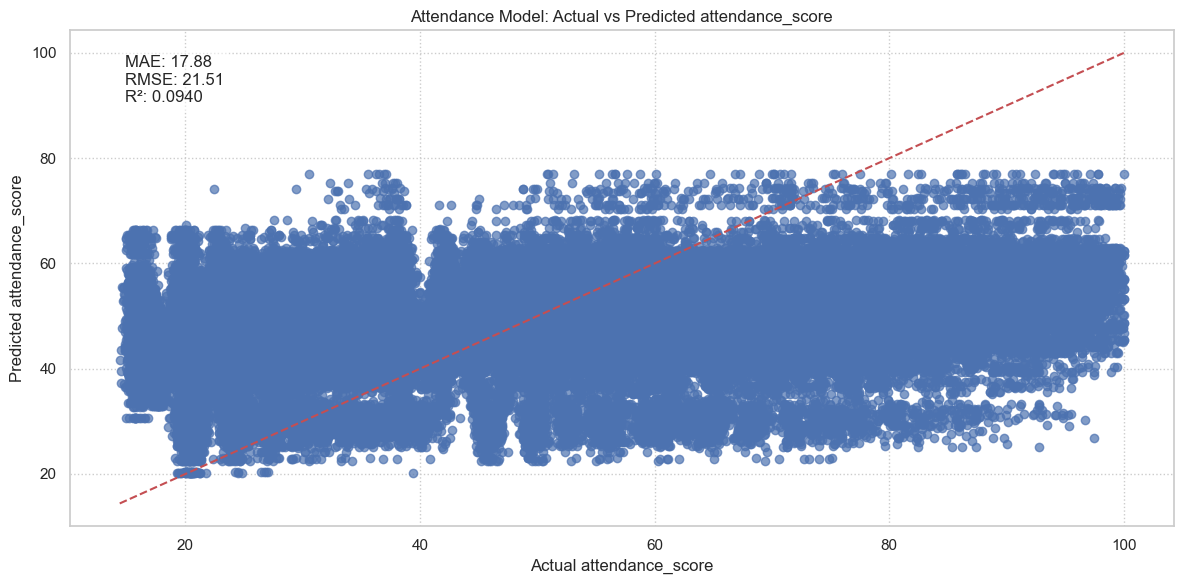

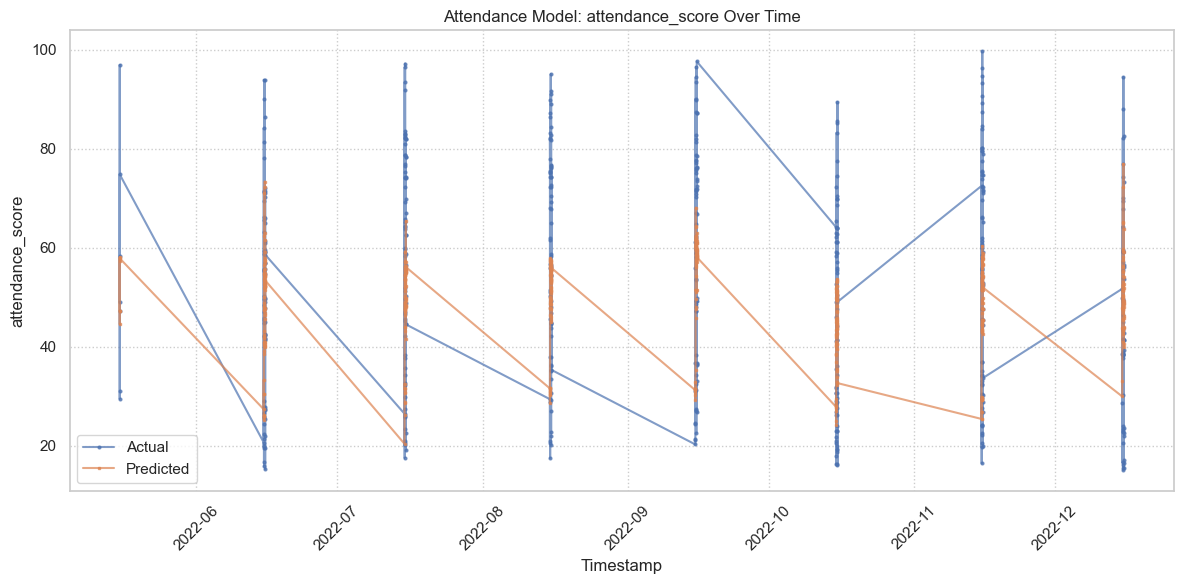

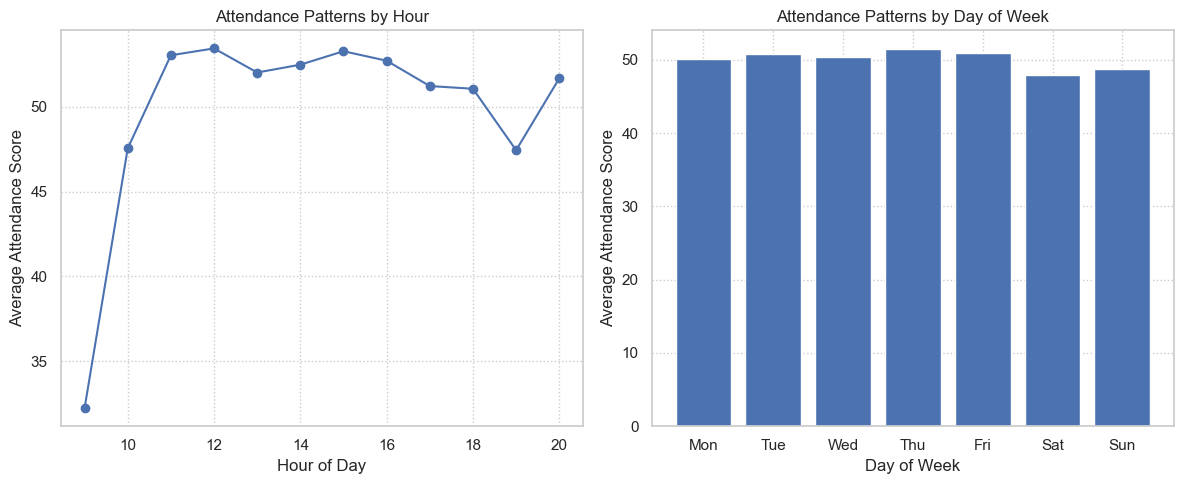


Top 5 highest attendance hours (actual):
  2017-06-15 13:00:00: Score 100, Wait Time 60.0min
  2017-09-15 13:00:00: Score 100, Wait Time 75.0min
  2017-09-15 14:00:00: Score 100, Wait Time 60.0min
  2017-11-15 16:00:00: Score 100, Wait Time 75.0min
  2017-11-15 18:00:00: Score 100, Wait Time 75.0min

Top 5 lowest attendance hours (actual):
  2017-10-15 16:00:00: Score 14, Wait Time 0.0min
  2018-06-15 14:00:00: Score 14, Wait Time 0.0min
  2018-11-15 15:00:00: Score 14, Wait Time 0.0min
  2017-09-15 16:00:00: Score 14, Wait Time 0.0min
  2018-11-15 15:00:00: Score 14, Wait Time 0.0min

5. Predicting attendance for all timestamps...
Generated attendance predictions for 358 training timestamps
Generated attendance predictions for 72 test timestamps
Test attendance range: 31.6 - 68.2

6. Preparing features for wait time model (both train and test will have attendance_score)...
Found attendance_score column with 503191 valid values
NaN values found: 160686
Selected 66 features: ['closed',

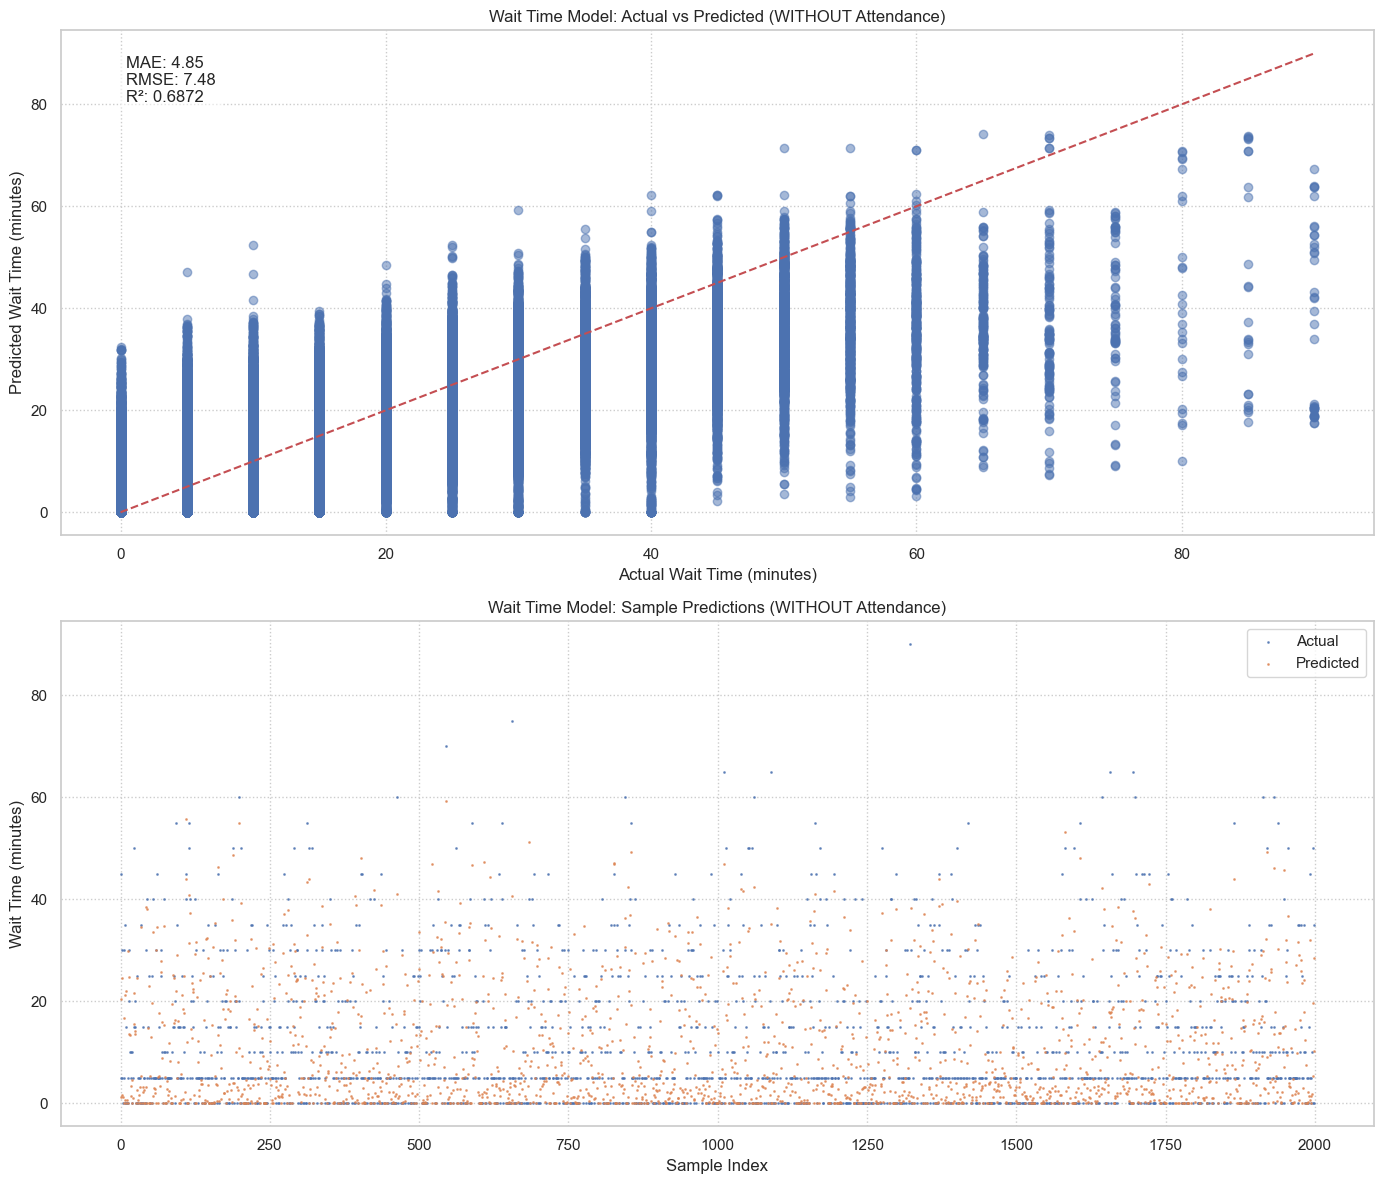

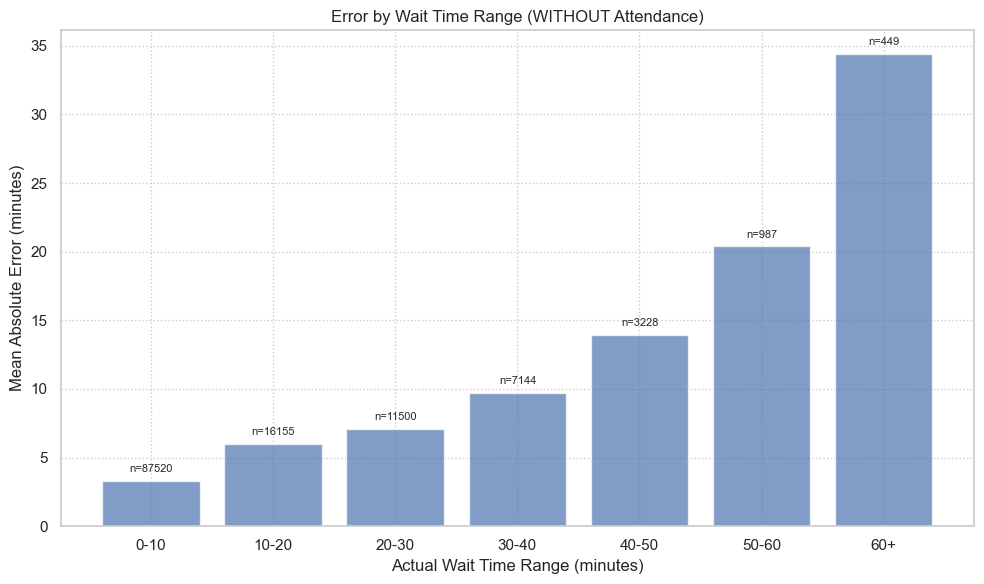


9b. Results WITH attendance...


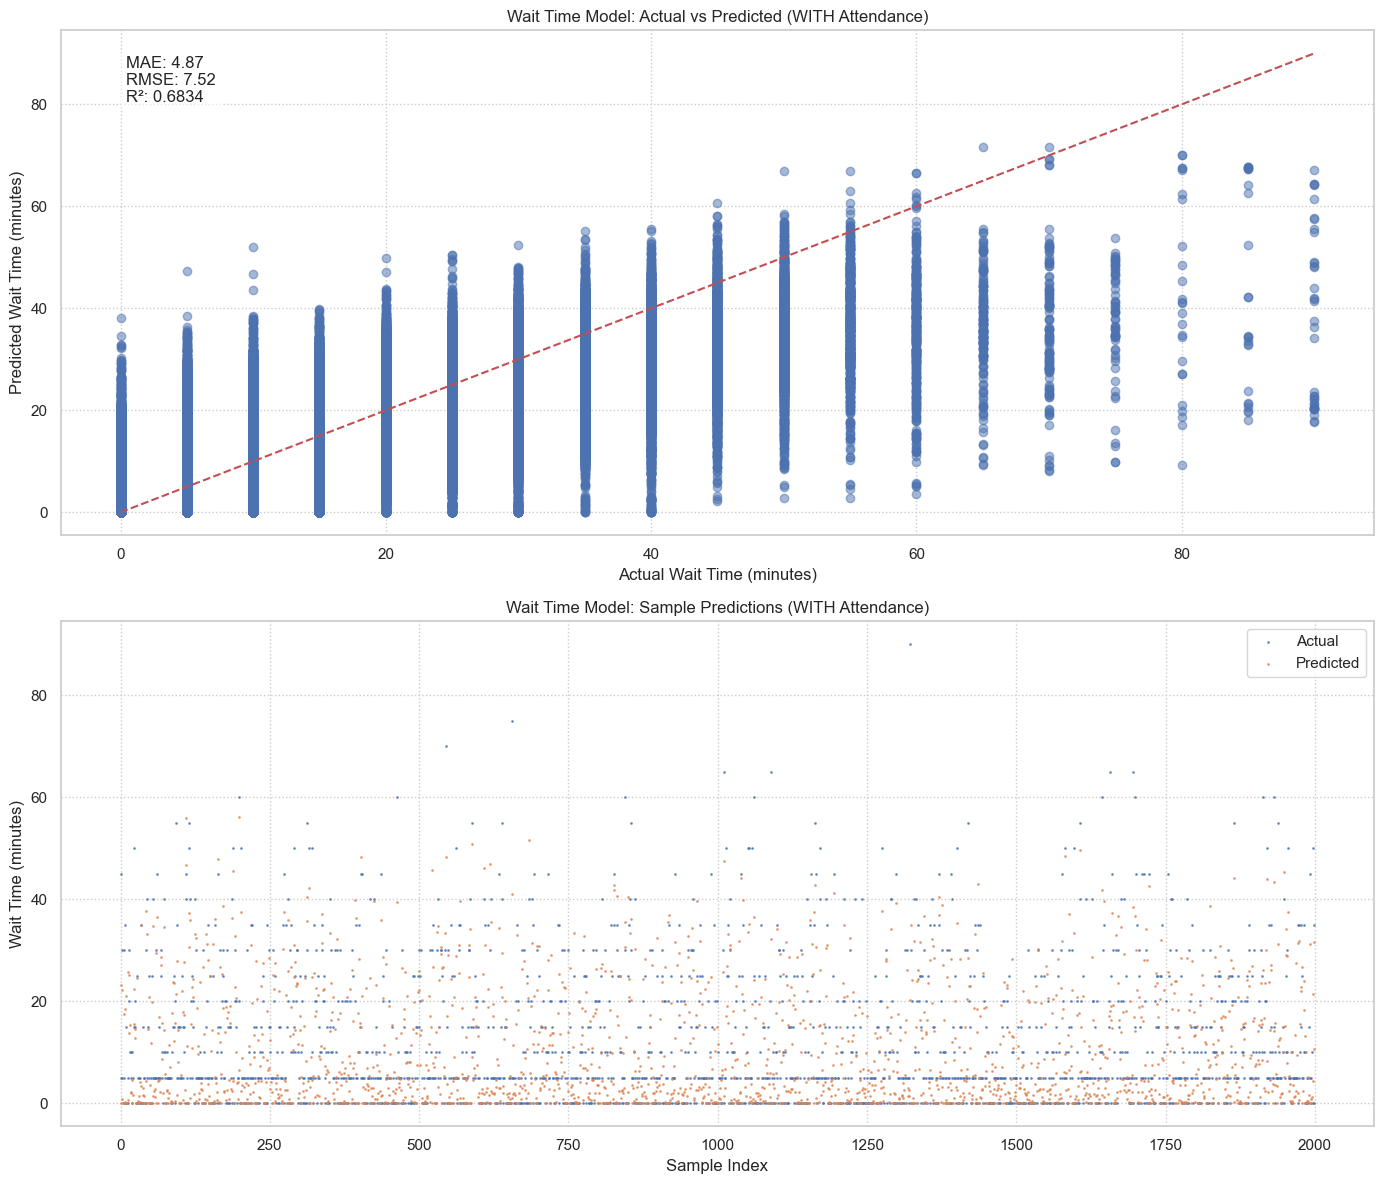

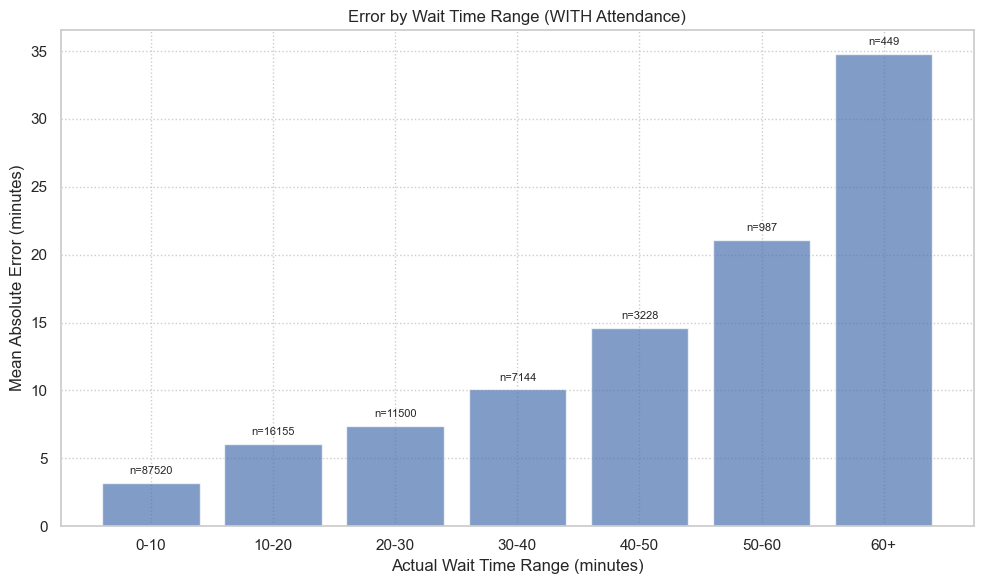


10. Model Comparison Summary...
Metric               WITHOUT Attendance   WITH Attendance      Improvement    
--------------------------------------------------------------------------------
MAE                  4.85                 4.87                 -0.4%
RMSE                 7.48                 7.52                 -0.6%
R²                   0.6872               0.6834               -0.6%
MAPE                 53.17                52.92                +0.5%

11. Demonstrating future predictions...
Future dates for prediction:
  - 2025-05-15
  - 2025-05-16
  - 2025-05-17
  - 2025-05-18
  - 2025-05-19
  - 2025-05-20
  - 2025-05-21
Predicted attendance for 70 future timestamps

Generated 70 future predictions

Sample future predictions:
         date  hour  predicted_wait  attendance_score
0  2025-05-15    10        0.000000         62.751958
1  2025-05-15    11        0.332865         73.308229
2  2025-05-15    12        0.412321         72.887682
3  2025-05-15    13        0.0000

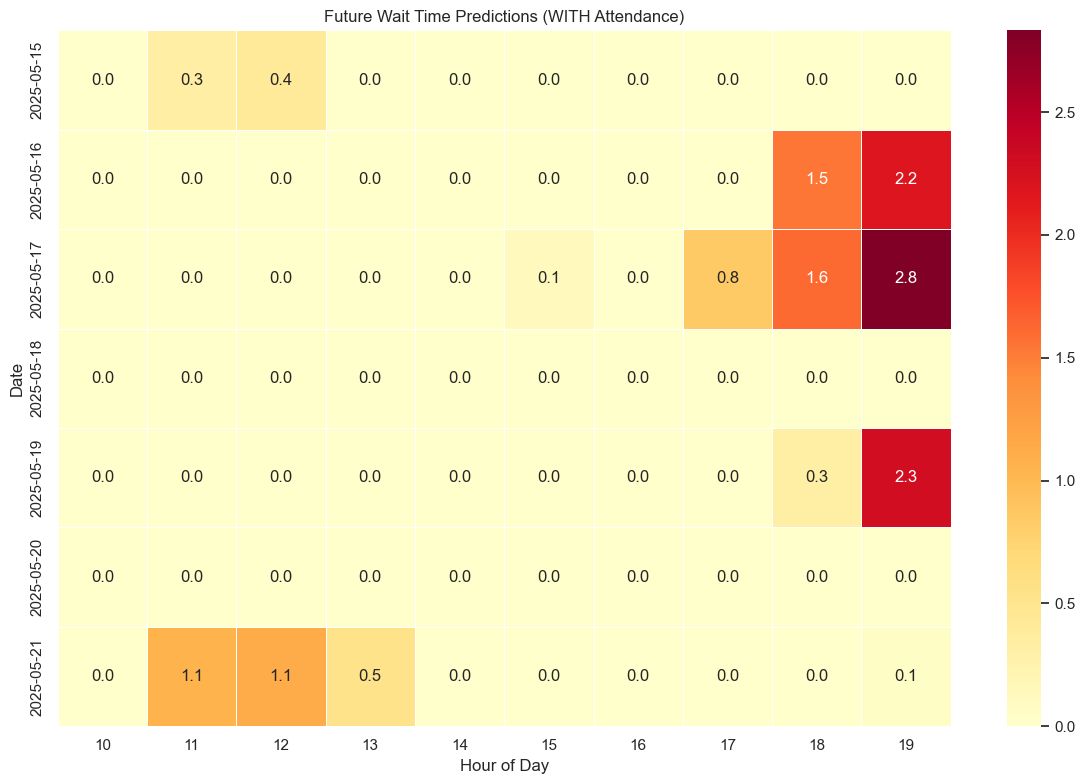

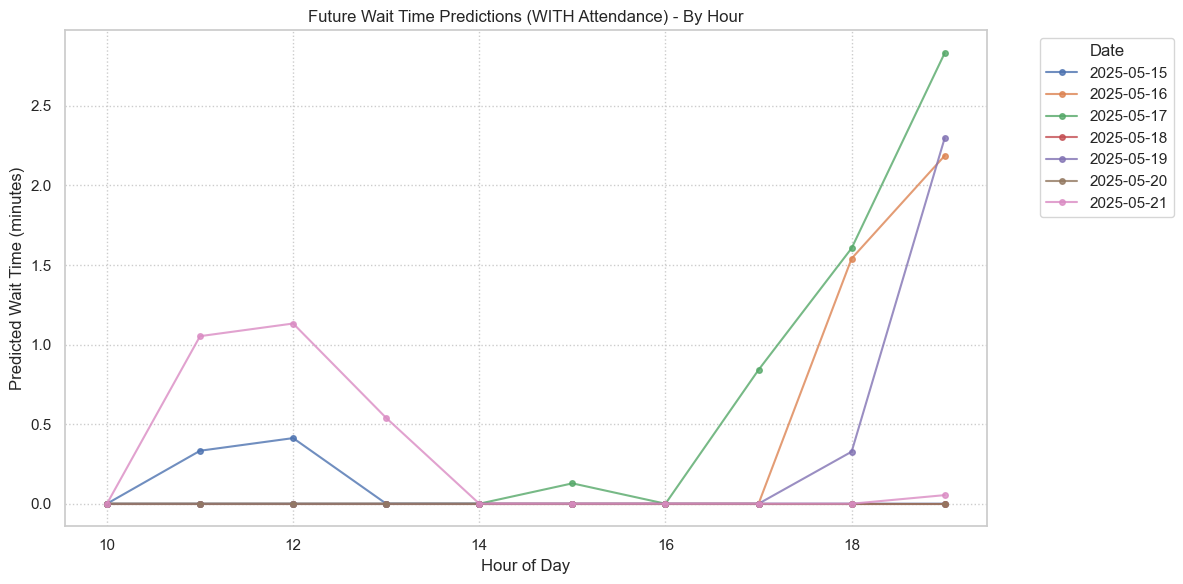


=== Pipeline completed successfully! ===
Key improvements:
✓ No data leakage - attendance calculated only from training data
✓ Attendance model uses only calendar features (no temporal wait features)
✓ Test predictions use predicted attendance, not actual
✓ Future predictions work without any historical wait time data
✓ Comprehensive visualizations for both models


In [ ]:
results = main()